# ch10. Boosting Tree

이제 대망의 decision tree 계열의 끝판왕 boosting tree를 배워볼 차례입니다. 사실 XGBoost, ligthGBM 등의 라이브러리가 너무 잘나와 있어서 가져다 쓰는 건 쉽습니다. 그래도 개념 측면을 살펴보겠습니다.

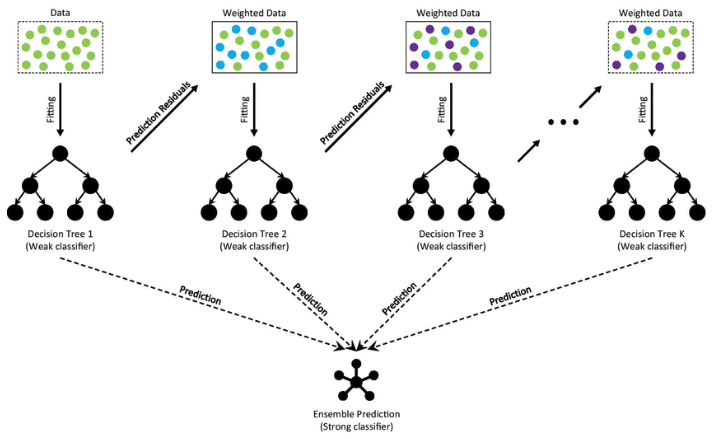

random forest의 경우, 여러 개의 트리를 병렬적으로 동시에 학습한 뒤에 앙상블을 하는 모델입니다. 하지만 단순히 랜덤하게 피쳐를 뽑아서 트리를 학습하시는 것보다 더 똑똑하게 할 수 있지 않을까요? 부스팅 트리는 먼저 트리를 하나 학습시키고, 해당 트리가 정답을 맞추지 못한 데이터에 가중치를 부여하여 다음 트리를 학습시킵니다. 이 과정을 반복하여 트리들을 학습시키고, 이들의 앙상블로 최종 결과를 내줍니다.

boosting tree에는 AdaBoost, XGBoost, lightGBM, CatBoost 등 여러 종류의 모델들이 있으며, 세부 구현은 다릅니다. 다만 최근에는 lightGBM이 뛰어난 성능과 가벼움으로 많은 사랑을 받고 있습니다. 이번 실습은 lightGBM 모델을 학습시킨 뒤, kaggle에 제출해보겠습니다. 

pip install lightgbm 명령어로 설치를 시도해보고, 실패시 아래 가이드를 참고하여 설치해보세요.
- windows: https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#windows
- mac: https://randomwalk.tistory.com/56

In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## lightGBM 모델 학습 및 성능 평가

In [2]:
import pandas as pd

train_df = pd.read_csv("./data/preprocessed_train.csv")
test_df = pd.read_csv("./data/preprocessed_test.csv")

x_train = train_df.drop(["PassengerId", "Survived"], axis=1)
y_train = train_df["Survived"]
x_test = test_df.drop(["PassengerId"], axis=1)

In [3]:
from sklearn.model_selection import StratifiedKFold

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [10, 30],
    "learning_rate": [0.01, 0.001],
    "num_leaves": [10, 20, 30],
    "subsample": [0.8, 1.0]
}

In [5]:
import lightgbm as lgb

model = lgb.LGBMClassifier()

In [6]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=stratified_kf,
    scoring="accuracy"
)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.001],
                         'n_estimators': [10, 30], 'num_leaves': [10, 20, 30],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [7]:
grid_search.best_params_

{'learning_rate': 0.01, 'n_estimators': 30, 'num_leaves': 10, 'subsample': 0.8}

In [8]:
grid_search.best_score_

0.7867365513778168

In [9]:
model = lgb.LGBMClassifier(**grid_search.best_params_)
model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=30, num_leaves=10,
               subsample=0.8)

## Feature Importance 시각화

lightGBM에 내장된 plot_importance 함수를 사용하여 어느 feature가 모델 학습에 결정적으로 영향을 끼쳤는지 확인해보겠습니다.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

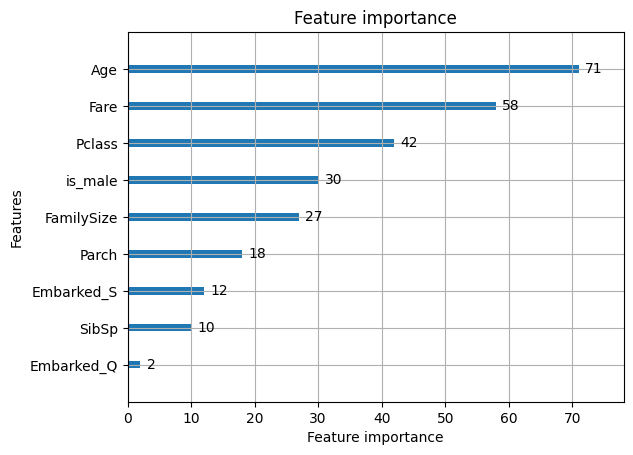

In [10]:
from lightgbm import plot_importance

plot_importance(model)

만일 우리가 실제 경진대회에 참여하는 입장이라면 다음과 같은 과정을 반복하면서 모델의 성능을 개선하면 됩니다.

- feature 전처리 과정 수정, scaling 조정
- FamilySize, IsAlone 같이 모델 성능에 영향을 주는 파생 변수를 추가
- 모델 학습시 파라미터 조정
- 불필요한 feature 제거하고 모델 다시 학습

## 정리

이번 챕터에서는 decision tree 계열의 꽃인 boosting tree 알고리즘의 대표 주자 lightGBM을 직접 사용해보았습니다. 그리고 정형 데이터를 이용한 예측 모델을 만들어보았고, kaggle 경진대회에 참여도 해보았습니다. decision tree 계열 모델들은 직관적이고, 해석 가능하며 성능이 매우 뛰어나서 현업에서 많이 사용되는 모델입니다. 이번에 확실하게 익히면 두고두고 요긴하게 쓰일 스킬이니, 꼭 복습해주세요.